This capstone project presents an application of the major Data Science concepts learned from the IBM Data Science Professional course on coursera.org. First an introduction would be presented explaining the business problem. Second, the data collection, cleaning and analysis would be presented. Third, we apply machine learning models to the data and finally we present the discussion and conclusion.

## Table of contents
* [Introduction](#introduction)
* [Data](#data)
* [Methodology](#methodology)
* [Analysis](#analysis)
* [Results and Discussion](#results)
* [Conclusion](#conclusion)

## 1. INTRODUCTION <a name="introduction"></a>

The Tech Industry is growing at an exponential rate and new jobs are springing up every day. With this rate of increase, it is very likely for Data Scientists to get jobs across different cities.

Apart from the remunerations and other benefits pertaining to a job offer, employees may still be interested in the social life of a new location compared to their current location. For example, a Data Scientist working in Toronto and gets new offers in Dallas and New York could be interested in how multicultural are these cities compared to Toronto. 

In this project, we apply machine learning models to analyze the similarities and dissimilarities between the 2020 top tech cities to get IT jobs and present a recommender system for choosing the best location to work based on the current social life of where a Data Scientist lives. 

This problem could also be extended to start-ups looking to relocate or open new branches and also for employees looking for a good vacation resort.

## 2. DATA COLLECTION <a name="data"></a>

* First we would apply **BeautifulSoup** for web scraping to get Top tech cities for IT jobs in 2020 from: https://dailyhive.com/toronto/toronto-tech-talent-top-ranking-north-america-report.
* Use **Google Maps API geocoding** to obtain the longitude and latitude for each of the cities

* Obtain data on the venues around each city using **Foursquare API** 

In [67]:
#Import modules
from bs4 import BeautifulSoup
import pandas as pd
import folium
import requests
import geocoder
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity
from yellowbrick.cluster import KElbowVisualizer
print("Modules imported succesfully.")

Modules imported succesfully.


# 2.1 Web scraping using beautifulsoup
Web scraping is the process of downloading valuable information available on websites pages. Beautifulsoup is a very popular python module that makes this process easy. Before applying Beautifulsoup, we would use the requests package to download the html data from the website. The html is parsed through beautifulsoup to get the data in a format easier to retrieve information from. To understand the website better and identify the tags of the key information to download, let us inspect the website first by right clicking on the page and left click on "inspect". In the image below, the html codes show up on the right pane and under the "Elements" tab, you can identify the "id" for the list.

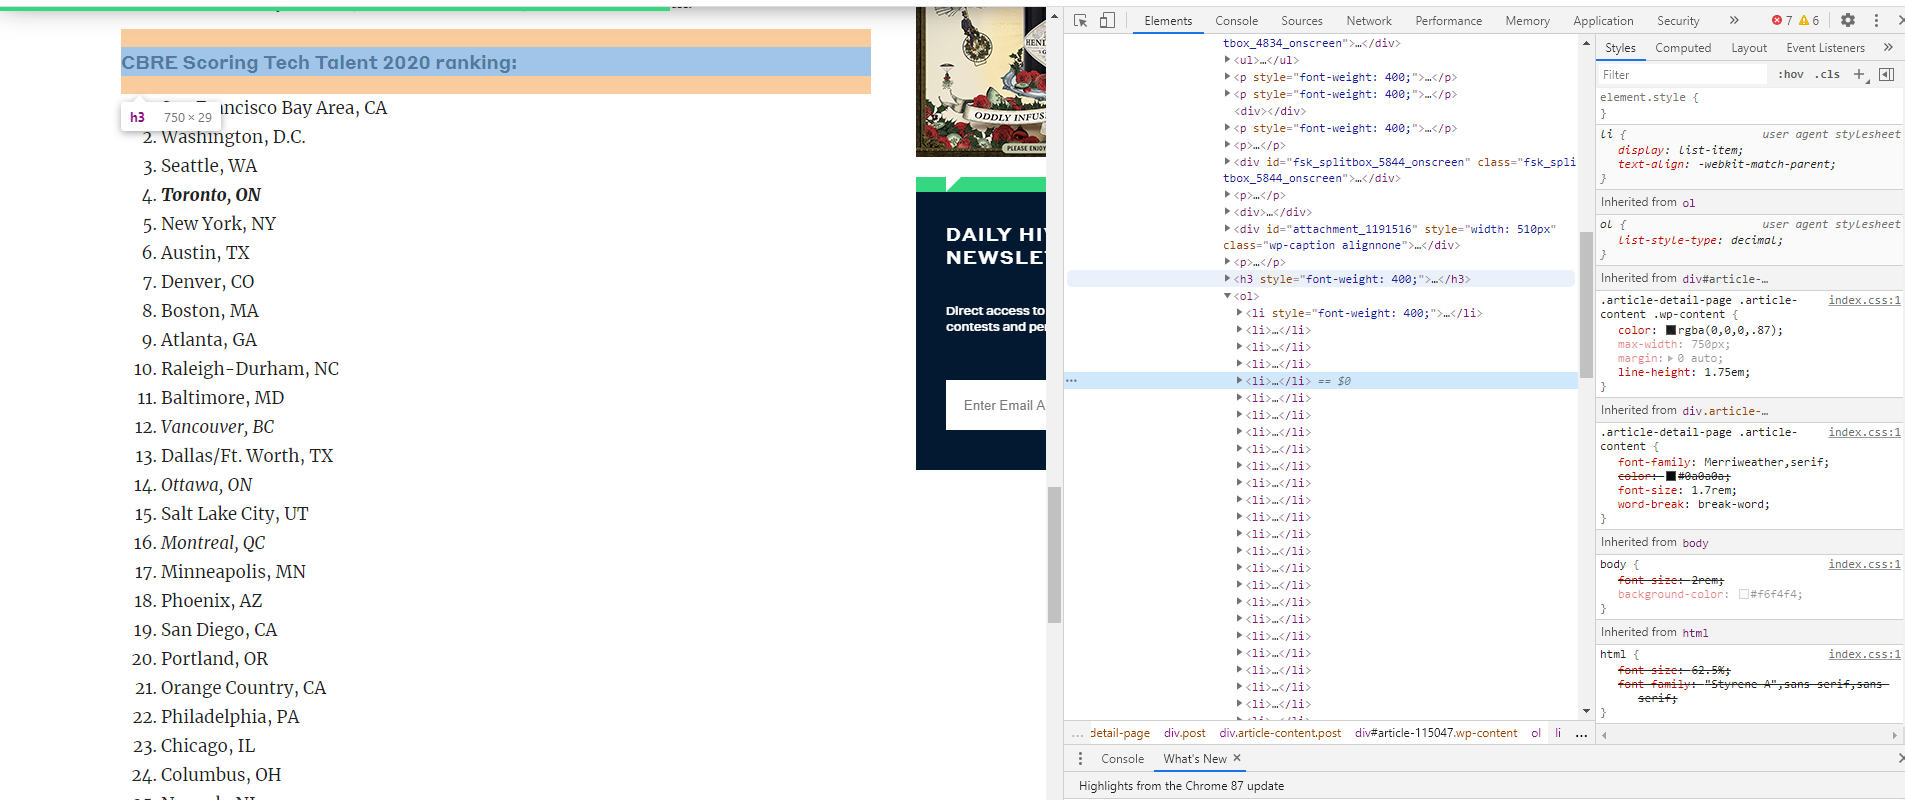

In [5]:
#run a get request to get details from the page
URL = "https://dailyhive.com/toronto/toronto-tech-talent-top-ranking-north-america-report"
page = requests.get(URL)

In [6]:
#prettify the data in html format
soup = BeautifulSoup(page.content, 'html.parser')
results = soup.find(id="article-115047")
print(results.prettify())

<div class="wp-content" id="article-115047">
 <p>
  It’s no secret that Ontario’s capital city is a leader in technology, but once again the city has been recognized as one of the top hubs for tech on the continent, beating out the likes of New York, Boston, Vancouver, and more.
 </p>
 <p>
  CBRE has released its Tech Talent report for 2020 and revealed that Toronto is now North America’s fourth top market for tech talent — falling
  <a href="https://dailyhive.com/toronto/toronto-tech-talent-cbre-ranking-2019" target="_blank">
   one place compared to last year
  </a>
  . According to the report, the city was a North American leader in tech employment growth “leading up to the COVID-19 pandemic, helping to fortify the city’s status as one of the world’s leading tech centre.”
 </p>
 <p style="font-weight: 400;">
  Toronto was also able to add 66,900 tech jobs over the past five years, the second-most of any North American city in the past five years, beat out only by the San Francisco’s

In [7]:
#get the text for all lists containing the list of top cities
tab_data = [cell.text for cell in results.find_all(["li"])]
df = pd.DataFrame(tab_data,dtype='string')
df.dtypes

0    string
dtype: object

In [8]:
df = df.loc[4:]
df.reset_index(inplace=True, drop=True)
df

,0
0,"San Francisco Bay Area, CA"
1,"Washington, D.C."
2,"Seattle, WA"
3,"Toronto, ON"
4,"New York, NY"
5,"Austin, TX"
6,"Denver, CO"
7,"Boston, MA"
8,"Atlanta, GA"
9,"Raleigh-Durham, NC"


In [9]:
#Split city and states
df.columns =['City']
new=df['City'].str.split(", ",expand=True)
df['City']=new[0]
df['State'] = new[1]
df.head()

,City,State
0,San Francisco Bay Area,CA
1,Washington,D.C.
2,Seattle,WA
3,Toronto,ON
4,New York,NY


In [10]:
# @hidden_cell
APIKey = ''

## 2.2 Geocoder API
The Google geocoder API allows user download location data such as latitude and longitude for a given location. You would have to create a project on Google console to create a new API key to download data. Google also provides $300 free credit to new accounts for a 90 day free trial period. That was more than enough to download the data needed for this project (more details here: https://cloud.google.com/free/docs/gcp-free-tier).

In [11]:
# Use the geocoder package to obtain latitude and longitude data for each city and add this to the dataframe, df
Latitude=[]
Longitude=[]
for index, row in df.iterrows():
    lat_lng_coords = None
    # loop until you get the coordinates
    while(lat_lng_coords is None):
        city = row['City']
        state = row['State']
        g = geocoder.google(city +','+ state,key=APIKey)
        lat_lng_coords = g.latlng
    Latitude.append(lat_lng_coords[0])
    Longitude.append(lat_lng_coords[1])
    

df['Latitude']=Latitude
df['Longitude'] =Longitude

df.head()

,City,State,Latitude,Longitude
0,San Francisco Bay Area,CA,37.827178,-122.291308
1,Washington,D.C.,38.907192,-77.036871
2,Seattle,WA,47.606209,-122.332071
3,Toronto,ON,43.653226,-79.383184
4,New York,NY,40.712775,-74.005973


In [12]:
#Get the longitude and latitude for North America and apply this in plotting a folium map
t = geocoder.google('North America', key =APIKey)
lat_lng_coords = t.latlng
na_lat =lat_lng_coords[0]
na_long = lat_lng_coords[1]
print('The geograpical coordinate of North America are {}, {}.'.format(na_lat,na_long ))

The geograpical coordinate of North America are 54.5259614, -105.2551187.


## 2.3 Folium map
The folium module is used to plot maps given the longitude and latitude. The folium map is applied here to show all the cities acros North America and would also be applied to show the city clusters.

In [15]:
#Map of North America showing the location of the top cities
map_na = folium.Map(location=[na_lat, na_long], zoom_start=2)

# add markers to map
for lat, lng, city, state in zip(df['Latitude'], df['Longitude'], df['City'], df['State']):
    label = '{}, {}'.format(city, state)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_na)  
    
map_na

## Get the data for venues across the cities using **Foursquare API**

## 2.4 Foursquare API
Using the fousquare API we would obtain data on venues across a specified radius in a city. First we would create a function that posts the request to obtain venues data for each city. More details on the Foursquare API available here: https://developer.foursquare.com/docs/api-reference/venues/details/

In [16]:
# @hidden_cell
CLIENT_ID = '' # your Foursquare ID
CLIENT_SECRET = '' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: 
CLIENT_SECRET:


In [17]:
#first we define a function to get all the venues around a radius for each city
def getNearbyVenues(names, latitudes, longitudes, radius=1000):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['City', 
                  'City Latitude', 
                  'City Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [18]:
na_venues = getNearbyVenues(names=df['City'],
                                   latitudes=df['Latitude'],
                                   longitudes=df['Longitude']
                                  )

San Francisco Bay Area
Washington
Seattle
Toronto
New York
Austin
Denver
Boston
Atlanta
Raleigh-Durham
Baltimore
Vancouver
Dallas/Ft. Worth
Ottawa
Salt Lake City
Montreal
Minneapolis
Phoenix
San Diego
Portland
Orange Country
Philadelphia
Chicago
Columbus
Newark
Los Angeles
Madison
Charlotte
Tampa
Pittsburgh


## 3. DATA EXPLORATION

Now that our data collection process is complete, we would now explore the data and transform the data to a form useful for the machine learning algorithm.

In [21]:
#Sanpshot of the data returned
na_venues.head(10)
#Venues vary from Print shops to coffee shops, Movie Theatre etc.

,City,City Latitude,City Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,San Francisco Bay Area,37.827178,-122.291308,PsPrint,37.822320,-122.289417,Print Shop
1,San Francisco Bay Area,37.827178,-122.291308,Pet Food Express,37.827293,-122.288368,Pet Store
2,San Francisco Bay Area,37.827178,-122.291308,Starbucks,37.828373,-122.289248,Coffee Shop
3,San Francisco Bay Area,37.827178,-122.291308,IKEA Swedish Food Market,37.831466,-122.292353,Scandinavian Restaurant
4,San Francisco Bay Area,37.827178,-122.291308,Eastbay Badminton Association,37.831568,-122.289200,Stadium
5,San Francisco Bay Area,37.827178,-122.291308,Joseph Emery Skate Spot,37.832606,-122.283828,Skate Park
6,San Francisco Bay Area,37.827178,-122.291308,Rudy's Can't Fail Cafe,37.830967,-122.285919,Diner
7,San Francisco Bay Area,37.827178,-122.291308,Pixar Theatre,37.832606,-122.283828,Movie Theater
8,San Francisco Bay Area,37.827178,-122.291308,Pixar Amphitheater,37.832606,-122.283828,Park
9,San Francisco Bay Area,37.827178,-122.291308,West Elm,37.833370,-122.293117,Furniture / Home Store


In [22]:
#check the shape of the data
na_venues.shape

(2761, 7)

In [23]:
#2761 venues were returned across all cities, let us see how many venues for each city
na_venues.groupby('City').count()

,City Latitude,City Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
City,,,,,,
Atlanta,82,82,82,82,82,82
Austin,100,100,100,100,100,100
Baltimore,100,100,100,100,100,100
Boston,100,100,100,100,100,100
Charlotte,100,100,100,100,100,100
Chicago,100,100,100,100,100,100
Columbus,100,100,100,100,100,100
Dallas/Ft. Worth,100,100,100,100,100,100
Denver,100,100,100,100,100,100


From the venues count, some cities are popular with a maximum of 100 venues returned and the least popular city is Raleigh-Durham with only 5 venues returned. To further explore our data, let us check the number of unique categories returned.

In [24]:
print('There are {} uniques categories.'.format(len(na_venues['Venue Category'].unique())))

There are 316 uniques categories.


There are 316 unique venue categories. Let us check how many times each category occurs in our data. 

In [25]:
na_venues['Venue Category'].value_counts()

Coffee Shop                171
Hotel                      166
American Restaurant         68
Café                        68
Bar                         64
                          ... 
Eye Doctor                   1
College Classroom            1
Lebanese Restaurant          1
Other Nightlife              1
North Indian Restaurant      1
Name: Venue Category, Length: 316, dtype: int64

From the list we can see that some venues occur only once. These may not be useful for our machine learning models and can lead to an increased variance in our data which would limit the effectiveness of our model. To improve our model accuracy, we would only work with venues that occur at least 30 times.

In [27]:
categories=na_venues['Venue Category'].value_counts()[na_venues['Venue Category'].value_counts()>=30]
cat = pd.DataFrame(categories)
cat.reset_index(level=0,inplace=True)
cat.columns=['Venue Category', 'count']
cat

,Venue Category,count
0,Coffee Shop,171
1,Hotel,166
2,American Restaurant,68
3,Café,68
4,Bar,64
5,Sandwich Place,62
6,Pizza Place,62
7,Park,60
8,Italian Restaurant,54
9,Theater,53


In [28]:
#filter the venues data to show only venues that occur more than 3o times.
na_venues_filtered = na_venues[na_venues['Venue Category'].isin(cat['Venue Category'])]
na_venues_filtered = na_venues_filtered.reset_index(drop=True)

In [29]:
#check the new venues count across cities
na_venues_filtered.groupby('City').count()

,City Latitude,City Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
City,,,,,,
Atlanta,27,27,27,27,27,27
Austin,49,49,49,49,49,49
Baltimore,40,40,40,40,40,40
Boston,55,55,55,55,55,55
Charlotte,53,53,53,53,53,53
Chicago,35,35,35,35,35,35
Columbus,54,54,54,54,54,54
Dallas/Ft. Worth,58,58,58,58,58,58
Denver,52,52,52,52,52,52


In [30]:
print('There are {} uniques categories.'.format(len(na_venues_filtered['Venue Category'].unique())))

There are 22 uniques categories.


There are now 22 unique categories. Next, a function is defined that returns a bar chart for venue categories count across any specified city. Let us see the venue categories for San Fracisco Bay Area

In [35]:
def city_cat_plot(df):
    df = pd.DataFrame(df['Venue Category'].value_counts())
    df.reset_index(level=0, inplace=True)
    df.columns = ['Venue Category', 'Count']
    fig_dims = (20, 10)
    fig, ax = plt.subplots(figsize=fig_dims)
    sns.barplot(x='Venue Category', y='Count',data=df,ax=ax)

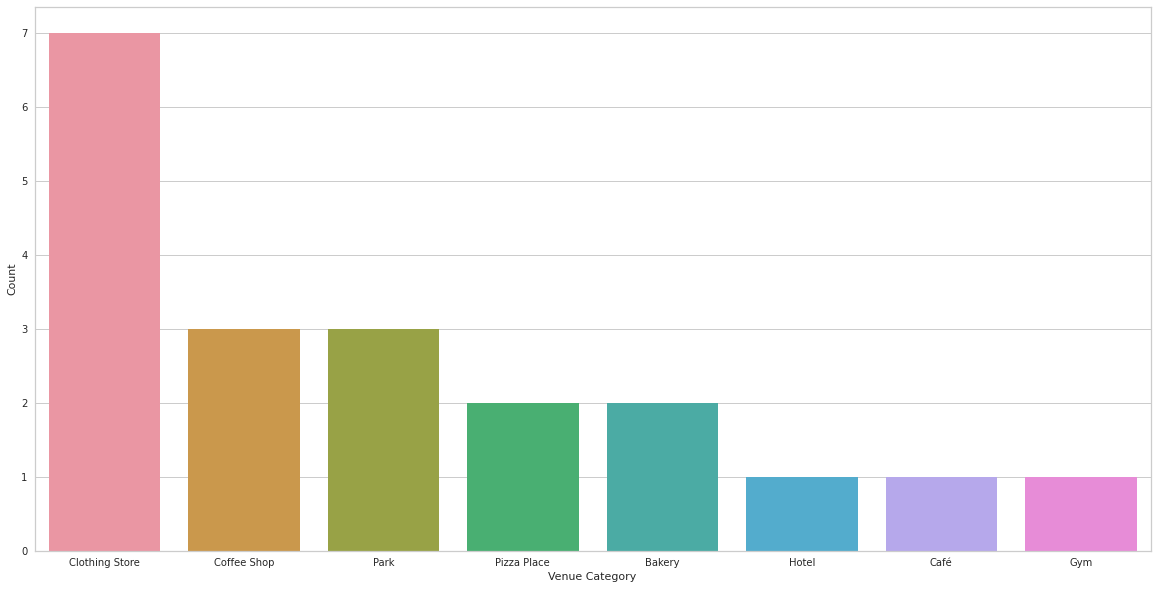

In [39]:
city_cat_plot(na_venues_filtered[na_venues_filtered['City']=='San Francisco Bay Area'])

The San Francisco Bay Area with 20 venues shows Clothing Stores as the most common venue category with 7 venues returned, followed by coffee shops and parks with 3 venues returned each. We can also show the most common venues by city in a dataframe.

In [52]:
#define a function returning the most common venues for a specified city
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [53]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['City']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
na_venues_sorted = pd.DataFrame(columns=columns)
na_venues_sorted['City'] = na_grouped['City']

for ind in np.arange(na_grouped.shape[0]):
    na_venues_sorted.iloc[ind, 1:] = return_most_common_venues(na_grouped.iloc[ind, :], num_top_venues)

na_venues_sorted.head()

,City,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Atlanta,Sandwich Place,Burger Joint,Coffee Shop,Theater,Bakery,Pizza Place,Park,Mexican Restaurant,Lounge,Gym
1,Austin,Hotel,Coffee Shop,Cocktail Bar,Bar,Steakhouse,Lounge,Italian Restaurant,Seafood Restaurant,Restaurant,New American Restaurant
2,Baltimore,American Restaurant,Hotel,Café,Coffee Shop,Theater,Italian Restaurant,Park,Bakery,Lounge,Seafood Restaurant
3,Boston,Italian Restaurant,Seafood Restaurant,Coffee Shop,Park,Bakery,Pizza Place,Hotel,Sandwich Place,Restaurant,American Restaurant
4,Charlotte,Hotel,Steakhouse,Theater,Park,Sandwich Place,Lounge,Pizza Place,American Restaurant,Restaurant,New American Restaurant


## 4. METHODOLOGY
In this session, the KMeans clustering machine learning model is applied to cluster cities based on the similarity in venues returned. A cosine-similarity measure is also applied to build a recommender system.

## 4.1 KMeans Clustering
The Kmeans model partitions a set of observations into some specified k clusters. Each observation is placed in a cluster based on it's distance from the mean or centroid of the cluster. To apply to KMeans cluster algorithm:

* First the categorical data is transformed to numerical data using one-hot encoding. 
* Then we group the rows by cities and taking the average of the frequency of occurrence of each Venue Category.
* Use the elbow method to identify the optimal k
* Cluster data using the optimal k and review results.

In [40]:
# one hot encoding
na_onehot = pd.get_dummies(na_venues_filtered[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
na_onehot['City'] = na_venues_filtered['City'] 

# move neighborhood column to the first column
fixed_columns = [na_onehot.columns[-1]] + list(na_onehot.columns[:-1])
na_onehot = na_onehot[fixed_columns]

na_onehot.head()

,City,American Restaurant,Bakery,Bar,Burger Joint,Café,Clothing Store,Cocktail Bar,Coffee Shop,Gym,...,Mexican Restaurant,New American Restaurant,Park,Pizza Place,Plaza,Restaurant,Sandwich Place,Seafood Restaurant,Steakhouse,Theater
0,San Francisco Bay Area,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,San Francisco Bay Area,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
2,San Francisco Bay Area,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,San Francisco Bay Area,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,San Francisco Bay Area,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0


In [41]:
na_grouped = na_onehot.groupby('City').mean().reset_index()
na_grouped

,City,American Restaurant,Bakery,Bar,Burger Joint,Café,Clothing Store,Cocktail Bar,Coffee Shop,Gym,...,Mexican Restaurant,New American Restaurant,Park,Pizza Place,Plaza,Restaurant,Sandwich Place,Seafood Restaurant,Steakhouse,Theater
0,Atlanta,0.037037,0.074074,0.000000,0.111111,0.037037,0.000000,0.037037,0.111111,0.037037,...,0.074074,0.000000,0.074074,0.074074,0.000000,0.000000,0.111111,0.037037,0.000000,0.074074
1,Austin,0.020408,0.000000,0.081633,0.020408,0.020408,0.000000,0.102041,0.142857,0.020408,...,0.040816,0.040816,0.020408,0.020408,0.000000,0.040816,0.000000,0.040816,0.081633,0.020408
2,Baltimore,0.125000,0.050000,0.025000,0.025000,0.100000,0.025000,0.000000,0.075000,0.025000,...,0.000000,0.025000,0.050000,0.050000,0.025000,0.025000,0.050000,0.050000,0.000000,0.075000
3,Boston,0.036364,0.072727,0.018182,0.018182,0.018182,0.018182,0.000000,0.109091,0.018182,...,0.000000,0.036364,0.090909,0.072727,0.018182,0.054545,0.054545,0.109091,0.018182,0.000000
4,Charlotte,0.056604,0.018868,0.018868,0.018868,0.018868,0.000000,0.018868,0.037736,0.018868,...,0.018868,0.037736,0.075472,0.075472,0.018868,0.056604,0.075472,0.037736,0.094340,0.075472
5,Chicago,0.057143,0.028571,0.057143,0.057143,0.057143,0.000000,0.028571,0.257143,0.000000,...,0.000000,0.028571,0.028571,0.028571,0.000000,0.000000,0.028571,0.028571,0.000000,0.142857
6,Columbus,0.111111,0.000000,0.092593,0.000000,0.092593,0.000000,0.018519,0.092593,0.037037,...,0.000000,0.018519,0.111111,0.092593,0.000000,0.037037,0.074074,0.000000,0.037037,0.055556
7,Dallas/Ft. Worth,0.086207,0.017241,0.068966,0.017241,0.051724,0.000000,0.068966,0.120690,0.068966,...,0.017241,0.034483,0.051724,0.000000,0.051724,0.000000,0.000000,0.051724,0.034483,0.017241
8,Denver,0.057692,0.019231,0.057692,0.038462,0.019231,0.019231,0.057692,0.076923,0.019231,...,0.038462,0.019231,0.019231,0.000000,0.000000,0.019231,0.134615,0.000000,0.038462,0.076923
9,Los Angeles,0.038462,0.076923,0.115385,0.000000,0.000000,0.038462,0.038462,0.192308,0.000000,...,0.076923,0.038462,0.038462,0.038462,0.115385,0.038462,0.000000,0.000000,0.000000,0.115385


In [44]:
na_grouped_clustering = na_grouped.drop('City', 1)

Text(0, 0.5, 'Inertia')

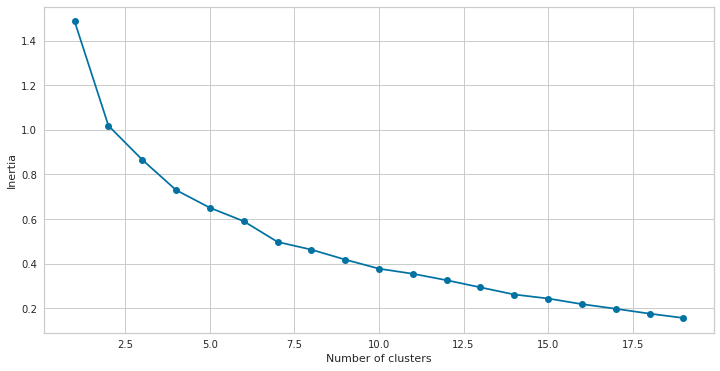

In [45]:
# fitting multiple k-means algorithms and storing the values in an empty list
SSE = []
for cluster in range(1,20):
    kmeans = KMeans(n_clusters = cluster, init='k-means++')
    kmeans.fit(na_grouped_clustering)
    SSE.append(kmeans.inertia_)

# converting the results into a dataframe and plotting them
frame = pd.DataFrame({'Cluster':range(1,20), 'SSE':SSE})
plt.figure(figsize=(12,6))
plt.plot(frame['Cluster'], frame['SSE'], marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')

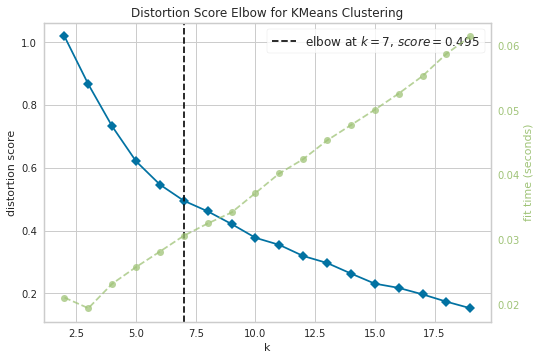

In [51]:
model=KMeans()
visualize=KElbowVisualizer(model,k=(2,20))
visualize.fit(na_grouped_clustering)
visualize.show()

In [55]:
# set number of clusters
kclusters = 6 # the optimal k is 6 as shown in the yellowbrick visualizer.
na_grouped_clustering = na_grouped.drop('City', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(na_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([5, 0, 5, 5, 0, 2, 0, 0, 0, 2], dtype=int32)

In [56]:
# add clustering labels
if 'Cluster Labels' in na_venues_sorted:
    del na_venues_sorted['Cluster Labels']
    na_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)
else:
    na_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

na_merged = df

# merge na_grouped with cities data (df) to add latitude/longitude for each city
na_merged = na_merged.join(na_venues_sorted.set_index('City'), on='City')

na_merged.head() # check the last columns!

,City,State,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,San Francisco Bay Area,CA,37.827178,-122.291308,3,Clothing Store,Park,Coffee Shop,Bakery,Pizza Place,Hotel,Café,Gym,Theater,Bar
1,Washington,D.C.,38.907192,-77.036871,0,Hotel,Steakhouse,Coffee Shop,American Restaurant,Sandwich Place,Pizza Place,Burger Joint,Cocktail Bar,Theater,Seafood Restaurant
2,Seattle,WA,47.606209,-122.332071,0,Coffee Shop,Hotel,Cocktail Bar,Seafood Restaurant,American Restaurant,New American Restaurant,Bakery,Café,Theater,Park
3,Toronto,ON,43.653226,-79.383184,1,Coffee Shop,Café,Hotel,Restaurant,Theater,Gym,American Restaurant,Pizza Place,Plaza,Seafood Restaurant
4,New York,NY,40.712775,-74.005973,1,Coffee Shop,American Restaurant,Café,Park,Hotel,Burger Joint,Cocktail Bar,Gym,Bakery,Clothing Store


# Cluster one:
The most common venues in the first cluster are hotels. We can infer this to be cities popular for hosting conferences or business meetings. More regular every day activities like visiting a coffee shop is sparsely common in the 2nd and 3rd most common venues. 

In [57]:
na_merged.loc[na_merged['Cluster Labels'] == 0].drop(['Latitude','Longitude','Cluster Labels'],axis=1)

,City,State,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,Washington,D.C.,Hotel,Steakhouse,Coffee Shop,American Restaurant,Sandwich Place,Pizza Place,Burger Joint,Cocktail Bar,Theater,Seafood Restaurant
2,Seattle,WA,Coffee Shop,Hotel,Cocktail Bar,Seafood Restaurant,American Restaurant,New American Restaurant,Bakery,Café,Theater,Park
5,Austin,TX,Hotel,Coffee Shop,Cocktail Bar,Bar,Steakhouse,Lounge,Italian Restaurant,Seafood Restaurant,Restaurant,New American Restaurant
6,Denver,CO,Hotel,Sandwich Place,Theater,Coffee Shop,Bar,Cocktail Bar,American Restaurant,Mexican Restaurant,Lounge,Steakhouse
11,Vancouver,BC,Hotel,Italian Restaurant,Seafood Restaurant,Restaurant,Café,Clothing Store,Coffee Shop,Sandwich Place,Steakhouse,Gym
12,Dallas/Ft. Worth,TX,Hotel,Coffee Shop,American Restaurant,Bar,Cocktail Bar,Gym,Seafood Restaurant,Plaza,Park,Café
17,Phoenix,AZ,Hotel,American Restaurant,Coffee Shop,Lounge,Pizza Place,Bar,Cocktail Bar,Gym,Theater,New American Restaurant
18,San Diego,CA,Hotel,Mexican Restaurant,Coffee Shop,Café,Bar,Theater,Steakhouse,Italian Restaurant,Sandwich Place,American Restaurant
21,Philadelphia,PA,Hotel,Clothing Store,American Restaurant,Bakery,Coffee Shop,Pizza Place,New American Restaurant,Steakhouse,Bar,Italian Restaurant
23,Columbus,OH,American Restaurant,Hotel,Park,Bar,Café,Coffee Shop,Pizza Place,Sandwich Place,Theater,Steakhouse


# Cluster two:
The most common venues in the second cluster are coffee shops. We can infer this to be with more busy regular daily activities and also business meetings seem to be regular as hotels come up twice in Ottawa and Montreal as the second most common venue. This is a key difference between cluster two and three.

In [58]:
na_merged.loc[na_merged['Cluster Labels'] == 1].drop(['Latitude','Longitude','Cluster Labels'],axis=1)

,City,State,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
3,Toronto,ON,Coffee Shop,Café,Hotel,Restaurant,Theater,Gym,American Restaurant,Pizza Place,Plaza,Seafood Restaurant
4,New York,NY,Coffee Shop,American Restaurant,Café,Park,Hotel,Burger Joint,Cocktail Bar,Gym,Bakery,Clothing Store
13,Ottawa,ON,Coffee Shop,Hotel,Restaurant,Café,New American Restaurant,Seafood Restaurant,Plaza,Gym,Park,Mexican Restaurant
15,Montreal,QC,Café,Hotel,Coffee Shop,Sandwich Place,Restaurant,Plaza,Pizza Place,Clothing Store,Park,Burger Joint
19,Portland,OR,Coffee Shop,Park,Café,Hotel,Italian Restaurant,Mexican Restaurant,American Restaurant,Pizza Place,Plaza,Lounge
20,Orange Country,CA,Coffee Shop,Sandwich Place,Park,Hotel,Plaza,Café,Theater,Gym,Bakery,Bar


# Cluster three:
The most common venues in the third cluster are coffee shops. Like cluster two, we can infer this to be cities with busy regular every day activities but the difference with cluster two is likely because these cities have more regular entertainment activities such as visiting theatres and bars.

In [59]:
na_merged.loc[na_merged['Cluster Labels'] == 2].drop(['Latitude','Longitude','Cluster Labels'],axis=1)

,City,State,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
14,Salt Lake City,UT,Hotel,Coffee Shop,Bakery,Bar,Pizza Place,Theater,Mexican Restaurant,Clothing Store,Cocktail Bar,Italian Restaurant
16,Minneapolis,MN,Coffee Shop,New American Restaurant,Theater,Bar,Hotel,Park,Italian Restaurant,Pizza Place,Burger Joint,American Restaurant
22,Chicago,IL,Coffee Shop,Theater,Hotel,Bar,Burger Joint,Café,American Restaurant,Park,New American Restaurant,Lounge
25,Los Angeles,CA,Coffee Shop,Theater,Bar,Plaza,Mexican Restaurant,Bakery,Clothing Store,Cocktail Bar,Italian Restaurant,New American Restaurant
28,Tampa,FL,Coffee Shop,Bar,Theater,Hotel,Pizza Place,Park,American Restaurant,Café,Mexican Restaurant,Restaurant


# Cluster four:
The most common venues in the fourth cluster are clothing stores and only one city, San Francisco Bay Area is on this cluster. We can infer this to be a city with busy weekends when people go shopping at clothing stores and relax at parks.

In [60]:
na_merged.loc[na_merged['Cluster Labels'] == 3].drop(['Latitude','Longitude','Cluster Labels'],axis=1)

,City,State,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,San Francisco Bay Area,CA,Clothing Store,Park,Coffee Shop,Bakery,Pizza Place,Hotel,Café,Gym,Theater,Bar


# Cluster five:
The most common venues in the fifth cluster are cafes and only one city Raleigh-Durham is on this cluster. Like cluster four, we can infer this to be a city with a busy weekend when people visit the Gym, Theatre and Steakhouses.

In [61]:
na_merged.loc[na_merged['Cluster Labels'] == 4].drop(['Latitude','Longitude','Cluster Labels'],axis=1)

,City,State,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
9,Raleigh-Durham,NC,Café,Gym,Theater,Steakhouse,Bakery,Bar,Burger Joint,Clothing Store,Cocktail Bar,Coffee Shop


# Cluster six:
The most common venues in the sixth cluster are restaurants. From this, we can infer this to be cities with readily available restaurant meals and would be an interesting location for people interested in eating out.

In [62]:
na_merged.loc[na_merged['Cluster Labels'] == 5].drop(['Latitude','Longitude','Cluster Labels'],axis=1)

,City,State,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
7,Boston,MA,Italian Restaurant,Seafood Restaurant,Coffee Shop,Park,Bakery,Pizza Place,Hotel,Sandwich Place,Restaurant,American Restaurant
8,Atlanta,GA,Sandwich Place,Burger Joint,Coffee Shop,Theater,Bakery,Pizza Place,Park,Mexican Restaurant,Lounge,Gym
10,Baltimore,MD,American Restaurant,Hotel,Café,Coffee Shop,Theater,Italian Restaurant,Park,Bakery,Lounge,Seafood Restaurant
24,Newark,NJ,Coffee Shop,Lounge,Italian Restaurant,Gym,Bar,Pizza Place,Sandwich Place,Burger Joint,Café,Park
26,Madison,WI,Sandwich Place,Coffee Shop,Bar,Hotel,Pizza Place,Burger Joint,American Restaurant,Café,Cocktail Bar,Theater


In [68]:
# create map
map_clusters = folium.Map(location=[na_lat, na_long], zoom_start=3)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**1 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(na_merged['Latitude'], na_merged['Longitude'], na_merged['City'], na_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

## 4.2 RECOMMENDER SYSTEM
In this section we would build a recommender system using a cosine similarity measure. The cosine of an angle is maximum with a value of 1 at 0 and minimum with a value of -1 at 180. In other words, the cosine is maximum when there is no difference between two vectors and minimum when the vectors are opposite. We would use the na_grouped data and the cosine similarity measure from scikit learn to develop this system.

In [69]:
df_cs = na_grouped.drop(['City'],axis=1)
df_cos_sim=pd.DataFrame(cosine_similarity(df_cs, df_cs))
df_cos_sim.columns=na_grouped['City']
df_cos_sim =df_cos_sim.set_index(na_grouped['City'])
df_cos_sim.head()

City,Atlanta,Austin,Baltimore,Boston,Charlotte,Chicago,Columbus,Dallas/Ft. Worth,Denver,Los Angeles,...,Portland,Raleigh-Durham,Salt Lake City,San Diego,San Francisco Bay Area,Seattle,Tampa,Toronto,Vancouver,Washington
City,,,,,,,,,,,,,,,,,,,,,
Atlanta,1.000000,0.523314,0.707220,0.555171,0.695177,0.699172,0.630809,0.514124,0.645710,0.562181,...,0.645600,0.187317,0.580221,0.608136,0.389932,0.650413,0.612098,0.593660,0.446673,0.582765
Austin,0.523314,1.000000,0.619331,0.541022,0.727678,0.740106,0.667608,0.885262,0.803579,0.552207,...,0.699426,0.094703,0.826699,0.849555,0.280545,0.846855,0.718579,0.613328,0.775480,0.826018
Baltimore,0.707220,0.619331,1.000000,0.683441,0.789398,0.747083,0.847629,0.756274,0.727015,0.554997,...,0.755193,0.337100,0.677134,0.702730,0.421038,0.743987,0.739341,0.749402,0.697675,0.734129
Boston,0.555171,0.541022,0.683441,1.000000,0.642134,0.551124,0.594033,0.533085,0.485965,0.523021,...,0.682053,0.085907,0.628966,0.506430,0.419564,0.617016,0.532892,0.524799,0.633885,0.563170
Charlotte,0.695177,0.727678,0.789398,0.642134,1.000000,0.597505,0.793296,0.681985,0.790043,0.457183,...,0.649844,0.104542,0.608392,0.674336,0.301321,0.666320,0.642693,0.518590,0.705533,0.836333


In [75]:
def recommend_city():  
    try:
        city = input("In which city do you live currently?: ")
        rec=pd.DataFrame(df_cos_sim[city].drop(city))
        rec =rec.sort_values(by=city,ascending=False)
        rec.reset_index(level=0,inplace=True)
        rec.columns=['City','Recommendation Score']
        rec.iloc[0]
        print("{} with a recommendation score of {:.4f}, is the recommended city you should relocate to".format(rec.iloc[0]['City'],rec.iloc[0]['Recommendation Score']))
    except:
        print("This city is not in the top tech cities analysed in this project. Please check and try again.")

In [72]:
recommend_city()

In which city do you live currently?: Boston
Philadelphia with a recommendation score of 0.6950, is the recommended city you should relocate to


In [73]:
recommend_city()

In which city do you live currently?: Toronto
Ottawa with a recommendation score of 0.8881, is the recommended city you should relocate to


In [76]:
recommend_city()

In which city do you live currently?: Bston
This city is not in the top tech cities analysed in this project. Please check and try again.


In [77]:
recommend_city()

In which city do you live currently?: San Francisco Bay Area
Philadelphia with a recommendation score of 0.6262, is the recommended city you should relocate to


In [78]:
recommend_city()

In which city do you live currently?: Baltimore
Columbus with a recommendation score of 0.8476, is the recommended city you should relocate to


## CONCLUSION
In conclusion, in this project we collected data for the Top Tech cities in 2020 across North America using **web scraping**, **Google geocoder API** and **Foursquare API**. With the Foursquare API we obtained data on different venue locations across the top tech cities. We transformed this data and performed an exploratory data analysis showing the top ten most common venues and a bar plot of these across cities. With this we performed a KMeans clustering and developed a recommender system. This project was performed based on data from the Foursquare API, there may be limitations in generalizing the conclusions from the clusters because of the limited number of venues from each city. The generalization of results can be improved by looking further into city neighborhoods where tech jobs are available and follow the same procedure developed in this project.
